In [43]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import cv2
import pandas as pd
import glob
import random
import matplotlib.pyplot as plt
import os

In [29]:
learning_rate = 0.001
batch_size = 10
epochs = 10


device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [34]:
train_path = 'C:/Users/sgold/laba5/train'
test_path = 'C:/Users/sgold/laba5/test'
val_path = 'C:/Users/sgold/laba5/val'
path_to_dataset=r"C:/Users/sgold/laba5/dataset/"

df = pd.read_csv(os.path.join(path_to_dataset, "C:/Users/sgold/laba5/dataset_csv.csv"), header=None, delimiter=";", names=['path_to_image', 'label'])
if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)

def train_loading(df, path, i):
    image_path = df.path_to_image[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.label[i]}.{i}.jpg'), image)

def test_loading(df, path, i):
    image_path = df.path_to_image[i]
    image = cv2.imread(image_path)
    if i - 880 > 109: 
        i = i - 1870
    else:
        i = i - 880
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)

for i in range(880):
    train_loading(df, train_path, i)

for i in range(880, 990):
    train_loading(df, test_path, i)

for i in range(990, 1100):
    train_loading(df, val_path, i)

for i in range(1100, 1980):
    train_loading(df, train_path, i)

for i in range(1980, 2090):
    train_loading(df, test_path, i)

for i in range(2090, 2200):
    train_loading(df, val_path, i)
    

train_list = glob.glob(os.path.join(train_path,'*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))
train_list, val_list = train_test_split(train_list, test_size=0.1)
    

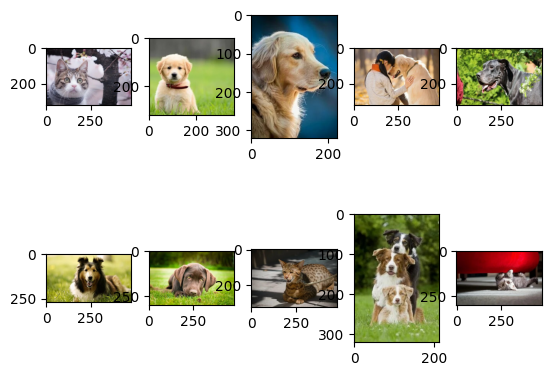

In [35]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()

In [50]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [76]:
from PIL import Image

class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('\\')[-1].split('.')[0]
        
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
            
        return img_transformed,label


train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

In [77]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out


In [78]:
model = Cnn().to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [79]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [80]:
print('Learning rate: 0.001, Batch size: 10')

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

epochs = 20

def train_loop (train_loader, val_loader, epochs):
    val_loss_list = []
    val_accuracy_list = []

    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in train_loader:
            data = torch.tensor(data).to(device)
            label = torch.tensor(label).to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        loss_list.append(epoch_loss.item())
        accuracy_list.append(epoch_accuracy.item())

        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        
        
        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0

            for data, label in val_loader:
                data = torch.tensor(data).to(device)
                label = torch.tensor(label).to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output,label)
                
                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)

            
            val_loss_list.append(epoch_val_loss.item())
            val_accuracy_list.append(epoch_val_accuracy.item())
                
            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
    

    num_epochs = [i+1 for i in range(epochs)]

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, loss_list, label = 'loss') 
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, accuracy_list, label = 'accuracy')

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for valid')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, val_loss_list, label = 'loss')
    fig.add_subplot(1,2,2)


Learning rate: 0.001, Batch size: 10


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.5657232999801636, train loss : 0.683384120464325


C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_12160\2660365062.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.635185182094574, val_loss : 0.6619083881378174
Epoch : 2, train accuracy : 0.6286165714263916, train loss : 0.6409809589385986
Epoch : 2, val_accuracy : 0.6481481194496155, val_loss : 0.6178485751152039
Epoch : 3, train accuracy : 0.6657233238220215, train loss : 0.613868772983551
Epoch : 3, val_accuracy : 0.6444445252418518, val_loss : 0.6249839067459106
Epoch : 4, train accuracy : 0.686163604259491, train loss : 0.5880493521690369
Epoch : 4, val_accuracy : 0.6814814805984497, val_loss : 0.5964401364326477
Epoch : 5, train accuracy : 0.6864780187606812, train loss : 0.582508385181427
Epoch : 5, val_accuracy : 0.6425926089286804, val_loss : 0.6196439266204834
Epoch : 6, train accuracy : 0.7062895894050598, train loss : 0.5754392743110657
Epoch : 6, val_accuracy : 0.6944444179534912, val_loss : 0.5741825699806213
Epoch : 7, train accuracy : 0.7176101803779602, train loss : 0.5457889437675476
Epoch : 7, val_accuracy : 0.7555555701255798, val_loss : 0.539713621

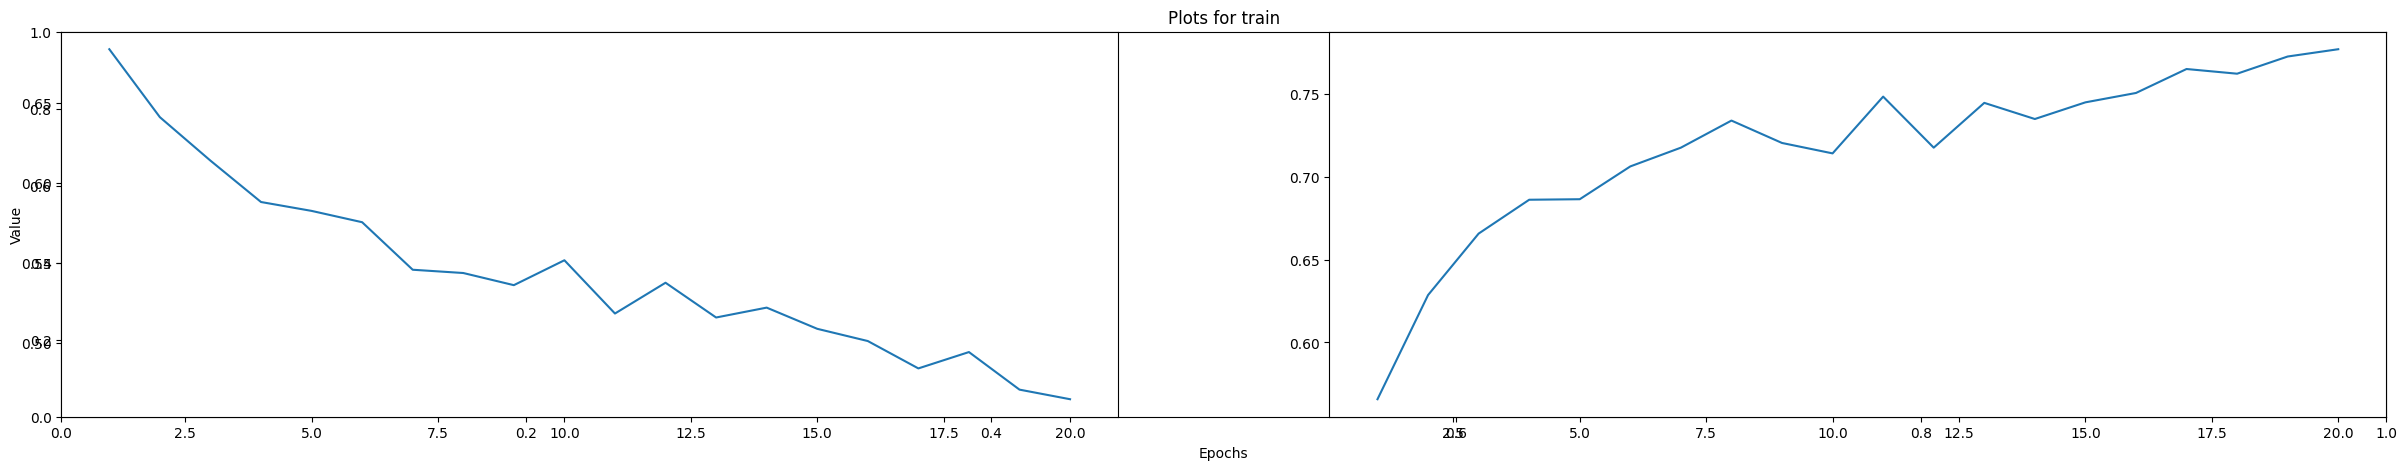

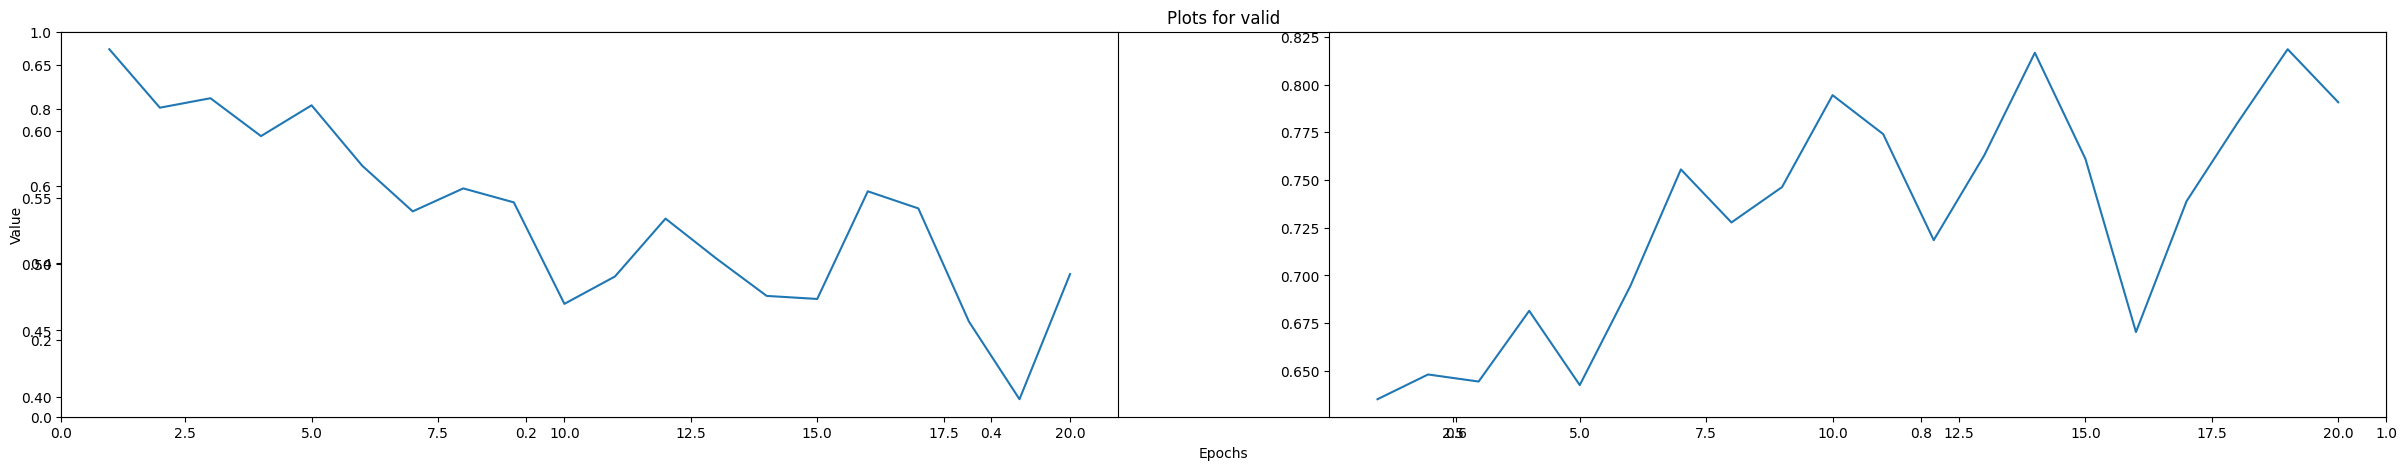

In [81]:
train_loop(train_loader, val_loader, epochs)